In [1]:
from utils import *

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from utils import CarTrajectoryNonLinear, UKF, plot_trajectory, conf_ellipse

from numpy.random import uniform
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
from numpy.random import randn
import scipy.stats
from tqdm.notebook import tqdm
from scipy.stats import multivariate_normal as mvn

from matplotlib import animation, rc

ModuleNotFoundError: No module named 'MPC'

In [ ]:
system = CarTrajectoryNonLinear()
states, measurements = system.get_data()

f = system.f
F_jacobian = system.F_jacobian
h = system.h
H_jacobian = system.H_jacobian
Q = system.Q
R = system.R

In [ ]:
extended_kalman_filter = UKF(f, h, Q, R, dim_m = 4, dim_y = 2)
state_estimates_UKF, cov_estimates_UKF = extended_kalman_filter.filter(measurements)
state_estimates_smoothed_UKF, cov_estimates_smoothed_UKF = extended_kalman_filter.smoother(state_estimates_UKF, cov_estimates_UKF)

In [ ]:
def systematic_resampling(weights):
    N = len(weights)
    positions = (np.arange(N) + np.random.random()) / N
    indexes = np.zeros(N, 'i')
    cumulative_sum = np.cumsum(weights)
    i, j = 0, 0
    while i < N:
        if positions[i] < cumulative_sum[j]:
            indexes[i] = j
            i += 1
        else:
            j += 1
    return indexes

def residual_resampling(weights):
    N = len(weights)
    
    # Step 1: deterministic resampling
    indexes = np.zeros(N, 'i')
    # take integer part of weights
    num_copies = (N * weights).astype(int)
    k = 0
    for i in range(N):
        for _ in range(num_copies[i]): # make n copies
            indexes[k] = i
            k += 1

    # Step 2: stochastic universal resampling on residuals
    residual = weights - num_copies     # get fractional part
    residual /= np.sum(residual)        # normalize
    cumulative_sum = np.cumsum(residual)
    cumulative_sum[-1] = 1.  # avoid round-off error
    # draw sample from uniform distribution
    u = np.random.uniform(0, 1/N)
    # uniform random numbers
    u = (np.arange(N) + u) / N
    i, j = 0, 0
    while (i < N) and (j < N):
        while u[i] > cumulative_sum[j]:
            j += 1
        while i < N and u[i] <= cumulative_sum[j]:
            indexes[i] = j
            i += 1
            
    return indexes

def stratified_resampling(weights):
    N = len(weights)
    # make N subdivisions, and chose a random position within each one
    positions = (np.random.random(N) + range(N)) / N

    indexes = np.zeros(N, 'i')
    cumulative_sum = np.cumsum(weights)
    i, j = 0, 0
    while i < N:
        if positions[i] < cumulative_sum[j]:
            indexes[i] = j
            i += 1
        else:
            j += 1
    return indexes

In [ ]:
P = np.eye(4)
m = states[0]

N = 500
n = len(measurements)
dim_m = 4
dim_y = 2

state_estimates = np.empty((n, dim_m))
cov_estimates = np.empty((n, dim_m, dim_m))
particle_history = np.empty((n, N, dim_m))
weights_history = np.empty((n, N))
indexes_history = np.empty((n, N), dtype=int)

# Draw N samples from the prior
particles = mvn(m, P).rvs(N)
weights = np.ones(N) / N

for k, y in tqdm(enumerate(measurements), total=n):
    # Prediction Step
    for i, particle in enumerate(particles):
        particles[i] = mvn(f(particle), Q).rvs()
        
    # Update Step
    for i, (weight, particle) in enumerate(zip(weights, particles)):
        weights[i] *= mvn(h(particle), R).pdf(y)
        
    weights /= np.sum(weights)

    m = np.average(particles, weights=weights, axis=0)
    P = np.sum([weights[i] * np.outer(particles[i] - m, particles[i] - m) for i in range(N)], axis=0)
    
    state_estimates[k] = m
    cov_estimates[k] = P
    
    particle_history[k] = particles
    weights_history[k] = weights

    # Resampling Step
    if 1. / np.sum(np.square(weights)) < N / 2:
        #indexes = residual_resampling(weights)
        indexes = stratified_resampling(weights)
        particles[:] = particles[indexes]
        weights.fill(1.0 / N)
    else:
        indexes = np.arange(N)

    indexes_history[k] = indexes
    

  0%|          | 0/100 [00:00<?, ?it/s]

In [2]:
state_estimates_smoothed = np.empty((n, dim_m))
state_estimates_smoothed[-1] = state_estimates[-1]
cov_estimates_smoothed = np.empty((n, dim_m, dim_m))
cov_estimates_smoothed[-1] = cov_estimates[-1]

for k in tqdm(range(n - 2, -1, -1)):
    m = state_estimates[k]
    P = cov_estimates[k]
    
    weights = weights_history[k]
    particles = particle_history[k]

    particles_transformed = np.empty_like(particles)
    for i, particle in enumerate(particles):
        particles_transformed[i] = f(particle) #+ np.random.multivariate_normal(np.zeros(dim_m), Q)
    
    m_pred = np.average(particles_transformed, weights=weights, axis=0)
    P_pred = np.sum([weights[i] * np.outer(particles_transformed[i] - m_pred, particles_transformed[i] - m_pred) for i in range(N)], axis=0) + Q
    
    D = np.sum([weights[i] * np.outer(particles[i] - m, particles_transformed[i] - m_pred) for i in range(N)], axis=0)
    G = D @ np.linalg.inv(P_pred)
    
    state_estimates_smoothed[k] = m + G @ (state_estimates_smoothed[k + 1] - m_pred)
    cov_estimates_smoothed[k] = P + G @ (cov_estimates_smoothed[k + 1] - P_pred) @ G.T
    

NameError: name 'n' is not defined

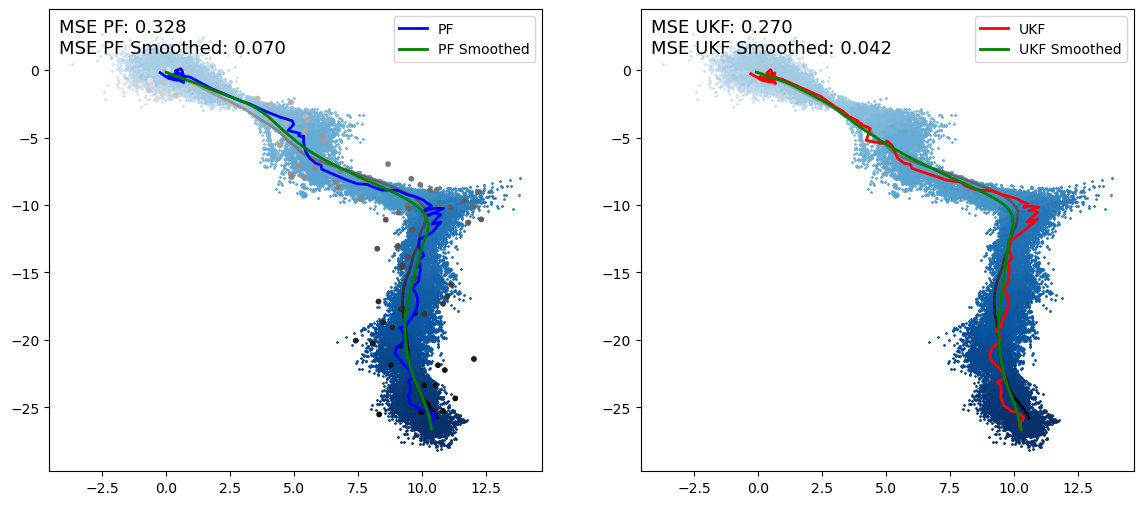

In [7]:
from matplotlib.collections import LineCollection
from matplotlib.cm import get_cmap  


fig, ax = plt.subplots(1, 2, figsize=(14, 6))
# Create a set of line segments
points = np.array([states[:, 0], states[:, 1]]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
greys = get_cmap('Greys')(np.linspace(0.4, 1, len(segments)))
lc1 = LineCollection(segments, colors=greys, linewidths=2)
lc2 = LineCollection(segments, colors=greys, linewidths=2)

# Plot line
ax[0].add_collection(lc1)
ax[1].add_collection(lc2)

# Plot particle history
blues = get_cmap('Blues')(np.linspace(0.2, 1.0, n))
for k in range(n):
    ax[0].scatter(particle_history[k, :, 0], particle_history[k, :, 1], s=1, color=blues[k])
    ax[1].scatter(particle_history[k, :, 0], particle_history[k, :, 1], s=1, color=blues[k])


# Plot measurements
greys = get_cmap('Greys')(np.linspace(0.2, 1, n))
ax[0].scatter(measurements[:, 0], measurements[:, 1], s=10, c=greys)

# Plot state estimates
ax[0].plot(state_estimates[:, 0], state_estimates[:, 1], color='blue', linewidth=2, label='PF')

# Plot state estimates smoothed
ax[0].plot(state_estimates_smoothed[:, 0], state_estimates_smoothed[:, 1], color='green', linewidth=2, label='PF Smoothed')

# Plot UKF
ax[1].plot(state_estimates_UKF[:, 0], state_estimates_UKF[:, 1], color='red', linewidth=2, label='UKF')

# Plot Smoothed UKF
ax[1].plot(state_estimates_smoothed_UKF[:, 0], state_estimates_smoothed_UKF[:, 1], color='green', linewidth=2, label='UKF Smoothed')

# Show MSE for PF and PF Smoothed on ax[0]
mse = np.mean((state_estimates[:, :2] - states[:, :2])**2)
mse_smoothed = np.mean((state_estimates_smoothed[:, :2] - states[:, :2])**2)
ax[0].text(0.02, 0.98, f'MSE PF: {mse:.3f}\nMSE PF Smoothed: {mse_smoothed:.3f}', transform=ax[0].transAxes, fontsize=13, verticalalignment='top')

mse = np.mean((state_estimates_UKF[:, :2] - states[:, :2])**2)
mse_smoothed = np.mean((state_estimates_smoothed_UKF[:, :2] - states[:, :2])**2)
ax[1].text(0.02, 0.98, f'MSE UKF: {mse:.3f}\nMSE UKF Smoothed: {mse_smoothed:.3f}', transform=ax[1].transAxes, fontsize=13, verticalalignment='top')

# Align legend top right
ax[0].legend(loc='upper right')
ax[1].legend(loc='upper right')

plt.show()

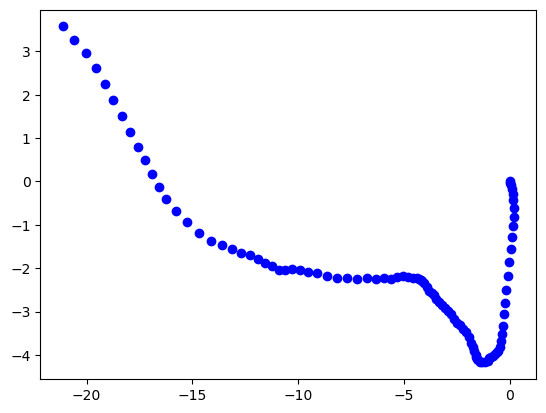

In [12]:
plt.plot(states[:, 0], states[:, 1], 'bo')